# Exploring Ad Impressions
This notebook 

In [1]:
!uv add pandas

Resolved 164 packages in 9ms
Audited 157 packages in 0.09ms


In [2]:
import numpy as np
import pandas as pd
import json

data = json.load(open("export/data/json/ad-engagements.json"))

In [3]:
engagement_1 = data[0]['ad']['adsUserData']['adEngagements']['engagements'][0]
print(json.dumps(engagement_1, indent=2))

{
  "impressionAttributes": {
    "deviceInfo": {
      "osType": "Ios",
      "deviceId": "2eVW2/fWZAazjwP/uvHAa4qkFW/vxfWcs2GVKmq/Lvo="
    },
    "displayLocation": "TimelineHome",
    "promotedTweetInfo": {
      "tweetId": "1626308935182589952",
      "tweetText": "IBM Security\u00ae X-Force\u00ae Threat Intelligence Index 2023 reveals all the top cyberthreats in your industry and region.",
      "urls": [],
      "mediaUrls": []
    },
    "advertiserInfo": {
      "advertiserName": "IBM",
      "screenName": "@IBM"
    },
    "matchedTargetingCriteria": [
      {
        "targetingType": "Follower look-alikes",
        "targetingValue": "@SwiftOnSecurity"
      },
      {
        "targetingType": "Age",
        "targetingValue": "25 and up"
      },
      {
        "targetingType": "Locations",
        "targetingValue": "United States of America"
      }
    ],
    "impressionTime": "2023-03-08 19:02:24"
  },
  "engagementAttributes": [
    {
      "engagementTime": "2023-03-08 

In [4]:
engagement_1.keys()

dict_keys(['impressionAttributes', 'engagementAttributes'])

In [5]:
impressions_data = []
targeting_data = []

impression_id = 0
dropped_impressions = 0
dropped_targeting = 0
for i in data:
    for eng in i['ad']['adsUserData']['adEngagements']['engagements']:
        imp_attr = eng['impressionAttributes']
        if imp_attr['displayLocation'] == "TimelineHome":
            try:
                impression = {
                    'impression_id': impression_id,
                    'impression_time': imp_attr['impressionTime'],
                    'tweet_text': imp_attr['promotedTweetInfo']['tweetText'],
                    'advertiser': imp_attr['advertiserInfo']['advertiserName']
                }
            except:
                dropped_impressions += 1
                impression_id += 1
                continue
            impressions_data.append(impression)
            for tgt in imp_attr['matchedTargetingCriteria']:
                try: 
                    targeting = {
                        'impression_id': impression_id,
                        'targeting_type': tgt['targetingType'],
                        'targeting_value': tgt['targetingValue']
                    }
                    targeting_data.append(targeting)
                except Exception as e:
                    dropped_targeting += 1
                    impression_id += 1
                    continue
            impression_id += 1

impressions_df = pd.DataFrame(impressions_data).set_index('impression_id')
targeting_df = pd.DataFrame(targeting_data)


# data validations
seems good

In [6]:
print(f"len(impressions_df): {len(impressions_df)}, dropped_impressions: {dropped_impressions}")


len(impressions_df): 1871, dropped_impressions: 27


In [7]:
timeline_home = 0
for i in data:
    for eng in i['ad']['adsUserData']['adEngagements']['engagements']:
        if eng['impressionAttributes']['displayLocation'] == 'TimelineHome':
            timeline_home += 1
print(f"TimelineHome engagements: {timeline_home}")

TimelineHome engagements: 1898


In [8]:
impressions_df.head()

,impression_time,tweet_text,advertiser
impression_id,,,
0,2023-03-08 19:02:24,IBM Security® X-Force® Threat Intelligence Ind...,IBM
1,2023-03-08 22:50:52,DYK that convenience store chains are blaming ...,The Electronic Payments Coalition
2,2023-03-08 22:50:52,We think about HIV every day so people like Wa...,GSK US
3,2023-03-08 14:57:44,Join us to learn how to protect more with less...,Microsoft Security
4,2023-03-08 14:57:58,Get the #NintendoSwitch games you crave and pl...,Nintendo of America


In [9]:
display(targeting_df)

,impression_id,targeting_type,targeting_value
0,0,Follower look-alikes,@SwiftOnSecurity
1,0,Age,25 and up
2,0,Locations,United States of America
3,1,Follower look-alikes,@TheDemocrats
4,1,Follower look-alikes,@HouseGOP
...,...,...,...
12350,1945,Follower look-alikes,@CocaCola
12351,1945,Locations,United States of America
12352,1945,Languages,English
12353,1945,Age,18 and up


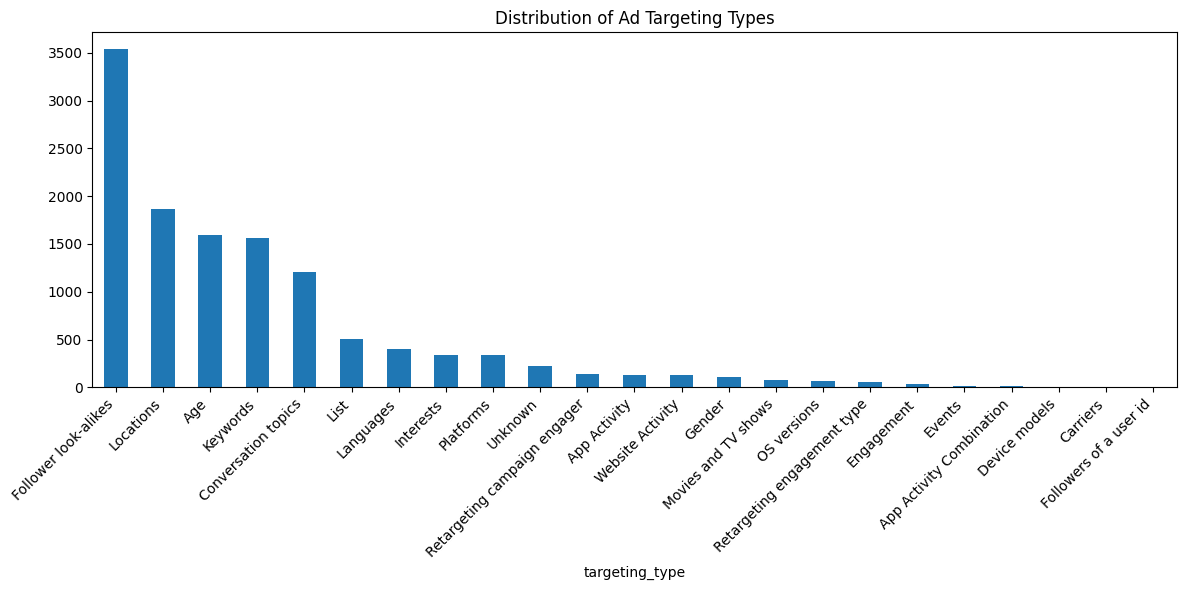

In [10]:
import squarify
import matplotlib.pyplot as plt
# 1. Visualize top targeting types distribution
targeting_type_counts = targeting_df['targeting_type'].value_counts()
plt.figure(figsize=(12,6))
targeting_type_counts.plot(kind='bar')
plt.title('Distribution of Ad Targeting Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Text(0.5, 1.0, 'Top Targeting Types and Their Most Common Values')

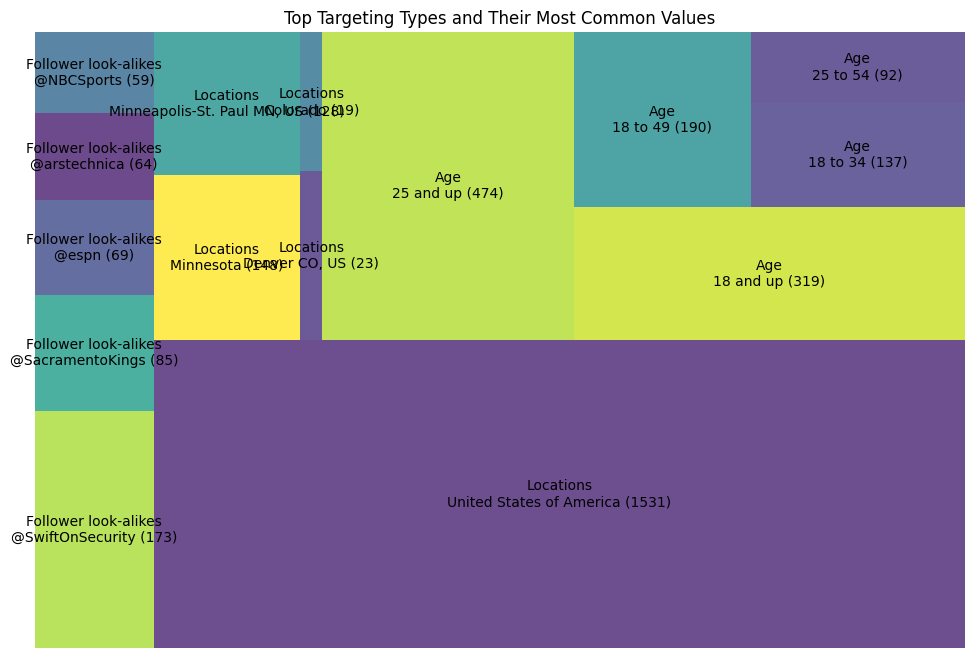

In [11]:
# 2. Create a treemap of targeting values for top targeting types

# Get top 3 targeting types and their values
top_types = targeting_type_counts.head(3).index
sizes = []
labels = []

for t_type in top_types:
    values = targeting_df[targeting_df['targeting_type'] == t_type]['targeting_value'].value_counts().head(5)
    sizes.extend(values.values)
    labels.extend([f"{t_type}\n{val} ({count})" for val, count in values.items()])

plt.figure(figsize=(12,8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.axis('off')
plt.title('Top Targeting Types and Their Most Common Values')


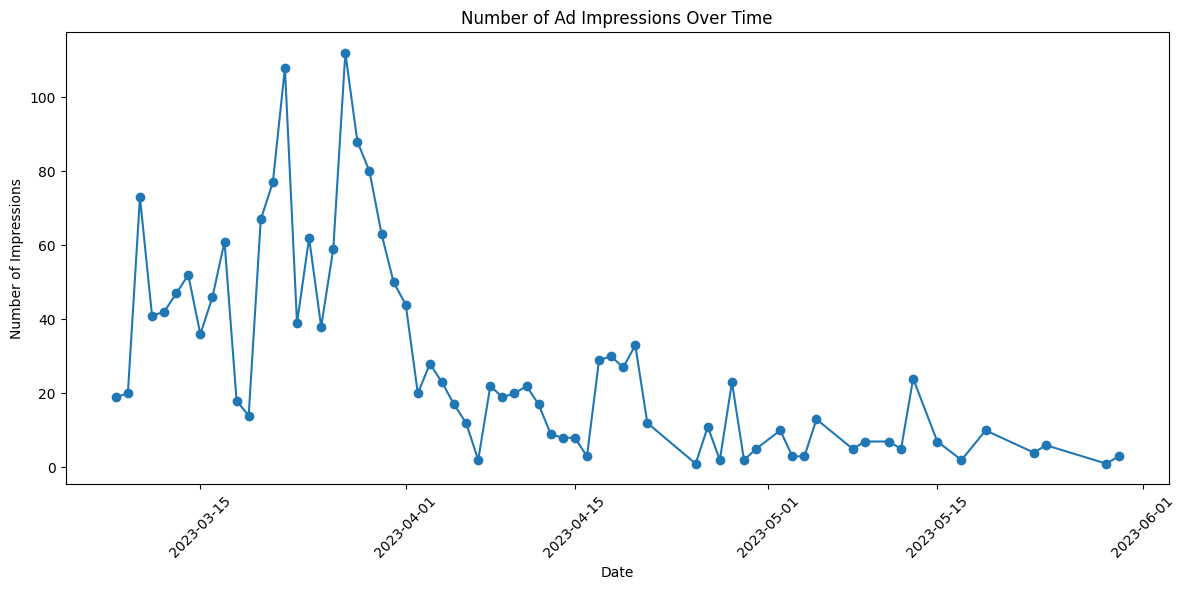

In [12]:
# 3. Timeline of impressions over time
impressions_over_time = impressions_df.reset_index()
impressions_over_time['impression_time'] = pd.to_datetime(impressions_over_time['impression_time'])
daily_impressions = impressions_over_time.groupby(impressions_over_time['impression_time'].dt.date).size()

plt.figure(figsize=(12,6))
daily_impressions.plot(kind='line', marker='o')
plt.title('Number of Ad Impressions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Impressions')
plt.xticks(rotation=45)
plt.tight_layout()